# Sam Tudberry - 1907632 - CSCM45J

# Building and comparison of CNN and ANN models for the land cover image classification task

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import seaborn as sns
from os.path import exists
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import skimage.feature

np.set_printoptions(suppress=True)

checkpoint_filepath = "checkpoint_file"
checkpoint_filepath_nn = "checkpoint_file_nn"
checkpoint_filepath_nn2 = "checkpoint_file_nn2"

### Loading data

In [2]:
DSimages = np.load('DS_Xdata.npy')
images = np.load('Xdata-1.npy')
labels = np.load('Ydata.npy')

pre_aug = False
pre_ext = False

In [3]:
if (exists('DS_Xdata_augmented.npy') and exists('Ydata_augmented.npy')):
    pre_aug = True
    DSimages = np.load('DS_Xdata_augmented.npy')
    labels = np.load('Ydata_augmented.npy')
    print("Augmented data loaded")
    
if (exists('hog_features.npy')):
    pre_ext = True
    x_data = np.load('hog_features.npy')
    print("Features loaded")

Augmented data loaded
Features loaded


### Data augmentation

Performing data augmentation to reduce overfitting and improve accuracy. Unfortunately, keras seems to have a bug in the current version that causes it's built in data augmentation to be very slow and generate lots of errors, so i've implemented manual data augmentation here which works but still takes some time.

In [3]:
# Only run this if data hasn't already been augmented since it takes a while
if (not pre_aug):
    
    value = DSimages.shape[0]
    
    # A loop for horizontal, vertical and horizontal+vertical flipping for each image
    
    print("Augmenting data, this may take a while...")
    
    for i in range(value):
        flipped = np.flipud(DSimages[i])
        DSimages = np.append(DSimages,[flipped],axis=0)
        labels = np.append(labels, labels[i])
        
    print("Stage 1 complete...")

    for i in range(value):
        flipped = np.fliplr(DSimages[i])
        DSimages = np.append(DSimages,[flipped],axis=0)
        labels = np.append(labels, labels[i])
        
    print("Stage 2 complete...")
        
    for i in range(value):
        flipped = np.fliplr(np.flipud(DSimages[i]))
        DSimages = np.append(DSimages,[flipped],axis=0)
        labels = np.append(labels, labels[i])
        
    print("Stage 3 complete...")

    np.save('DS_Xdata_augmented', DSimages)
    np.save('Ydata_augmented', labels)
    
    print("Finished.")

## CNN

This section contains the building, training, testing and evaluation of the CNN model

### Performing train/test/val split

In [4]:
# Data is automatically shuffled by the train_test_split function.
# Random state 2 is used to preserve consistency.

# First split into train and test with 90-10 split
x_train, x_test, y_train, y_test = train_test_split(DSimages, labels, train_size=0.9, random_state=2)

# Split the remaining train data into train and val using adjusted values to get the correct split
val_split = y_test.shape[0]/y_train.shape[0]
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, random_state=2)

In [5]:
# Normalising the data
x_ntrain = np.divide(x_train,255)
x_nval = np.divide(x_val,255)
x_ntest = np.divide(x_test,255)

classes = len(np.unique(y_train))

i_shape = x_train.shape[1:]

### Building CNN model

In [233]:
# Checkpoint callback for saving best weights for validation accuracy during training
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,save_weights_only=True,monitor='val_sparse_categorical_accuracy',
                                                mode='max',save_best_only=True)

# Multiple dropout layers were introduced along with batch normalisation and an L2 kernel regularizer on 
# the first fully connected layer. This approach was found to achieve the best overall performance in terms
# of balancing accuracy with reduced overfitting.

# The architecture itself is based on some common approaches, as described in the accompanying report.

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(32,3,padding='same',activation=tf.nn.relu,input_shape=i_shape))
cnn_model.add(tf.keras.layers.Conv2D(32,3,padding='same',activation=tf.nn.relu))
cnn_model.add(tf.keras.layers.MaxPool2D())
cnn_model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation=tf.nn.relu))
cnn_model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation=tf.nn.relu))
cnn_model.add(tf.keras.layers.MaxPool2D())
cnn_model.add(tf.keras.layers.Dropout(0.2))
cnn_model.add(tf.keras.layers.Conv2D(128,3,padding='same',activation=tf.nn.relu))
cnn_model.add(tf.keras.layers.Conv2D(128,3,padding='same',activation=tf.nn.relu))
cnn_model.add(tf.keras.layers.MaxPool2D())
cnn_model.add(tf.keras.layers.Dropout(0.2))
cnn_model.add(tf.keras.layers.Conv2D(256,3,padding='same',activation=tf.nn.relu))
cnn_model.add(tf.keras.layers.Conv2D(256,3,padding='same',activation=tf.nn.relu))
cnn_model.add(tf.keras.layers.MaxPool2D())
cnn_model.add(tf.keras.layers.Dropout(0.4))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_regularizer='l2'))
cnn_model.add(tf.keras.layers.Dropout(0.4))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
cnn_model.add(tf.keras.layers.Dropout(0.2))
cnn_model.add(tf.keras.layers.Dense(classes, activation=tf.nn.softmax))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=tf.keras.metrics.SparseCategoricalAccuracy())

### Training model by fitting to training data

After 100 epochs, the validation accuracy of both this model and the ANN model did not continue to meaningfully improve. 100 epochs may even be an unnecessarily high number, however the process can be carried out relatively quickly using GPU acceleration so it's not a major inconvenience.

In [ ]:
# Training for 100 epochs using the val and train data, using the checkpoint callback

with tf.device('/GPU:0'):
    cnn_history = cnn_model.fit(x_ntrain, y_train, epochs=100, validation_data=(x_nval,y_val), callbacks=[checkpoint])

### Testing model

It's important to note that while loss is present as a testing metric here, it was not discussed in the report evaluation due to lack of space. It also directly correlated with accuracy for both models and therefore didn't add anything new to the discussion.

27/27 [==============================] - 0s 8ms/step - loss: 0.2462 - sparse_categorical_accuracy: 0.9571


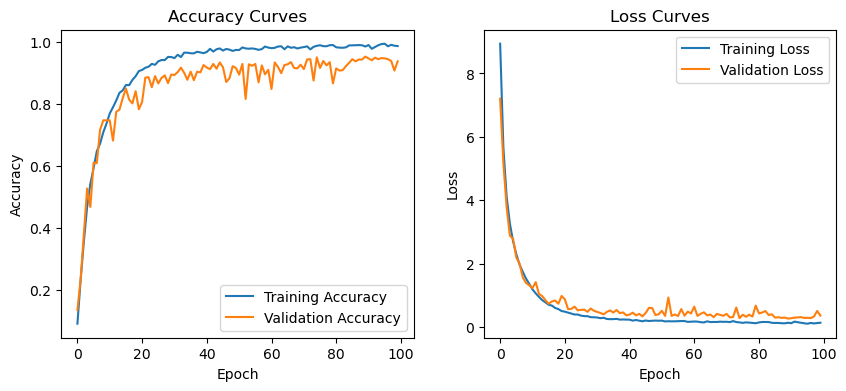

In [234]:
# Loading best weights
#nn_model.load_weights('Weights\\CNN\checkpoint_file_candidate3') # <-- loading from a file with best model weights overall
cnn_model.load_weights(checkpoint_filepath) # <-- load most recent best weights

# Testing model using test data
predictions = cnn_model.predict(x_ntest)

# Using prediction values to determine predicted classes
cnn_predictedLabels=np.argmax(predictions,axis=1)

# Evaluating model testing proficiency
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(x_ntest,y_test)

# The exception is caught for the case where this cell is run when no training history
# exists for the model
try: cnn_history
except NameError: cnn_history = None

if (cnn_history != None):
    cnn_historyDict = cnn_history.history

    # Plotting accuracy and loss graph from values acquired during training.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.plot(cnn_historyDict['sparse_categorical_accuracy'], label='Training Accuracy')
    ax1.plot(cnn_historyDict['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    ax1.set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy Curves')
    ax2.plot(cnn_historyDict['loss'], label='Training Loss')
    ax2.plot(cnn_historyDict['val_loss'], label='Validation Loss')
    ax2.set(xlabel='Epoch', ylabel='Loss', title='Loss Curves')
    ax1.legend()
    ax2.legend()
    plt.show()

### Accuracy and loss of CNN model on train, val and test datasets

In [235]:
val_accuracy_array = cnn_historyDict['val_sparse_categorical_accuracy']
val_loss_array = cnn_historyDict['val_loss']
train_accuracy_array = cnn_historyDict['sparse_categorical_accuracy']
loss_array = cnn_historyDict['loss']

index = np.argmax(val_accuracy_array)

val_accuracy_cnn = val_accuracy_array[index]
val_loss_cnn = val_loss_array[index]
train_accuracy_cnn = train_accuracy_array[index]
train_loss_cnn = loss_array[index]


print("train_acc:",train_accuracy_cnn, "- train_loss:",train_loss_cnn)
print("val_acc:", val_accuracy_cnn, "- val_loss:",val_loss_cnn)
print("test_acc:", test_accuracy_cnn, "- test_loss:",test_loss_cnn)

train_acc: 0.9860119223594666 - train_loss: 0.13861948251724243
val_acc: 0.9535714387893677 - val_loss: 0.2709946930408478
test_acc: 0.9571428298950195 - test_loss: 0.24624104797840118


### Evaluating performance
Looking at the results for this model using the best weights achieved when trialling, the CNN evidently performs signficantly better than the ANN does for this image classification task, which is not surprising since CNNs were designed for such tasks. From the graph, it's evident that the model does not really suffer from significant overfitting as a result of a number of measures put in place to combat it. The performance is not perfect however and there is still room for improvement in both closing the gap between validation and training results as well as in bringing both loss and accuracy values down and up respectively to as close to 0 and 100 as possible. Comparatively though, the CNN model is better than the ANN model in every way when it comes to performance and is also less complicated to set up, not requiring any feature extraction or dimension reduction methods to achieve a high accuracy. It seems then that based on the experimentation performed here, the CNN is well suited to performing the landcover image classification task, being capable of achieving high training, validation and testing accuracy results.

### Confusion Matrix
Confusion matrix displaying percentages of predictions made.
The values along the diagonal represent the correct predictions, suggesting that this CNN model performs relatively well, achieving 100% prediction accuracy in a number of categories. The model is let down by its ability to correctly classify classes 11 and 12 as reliably as the others.

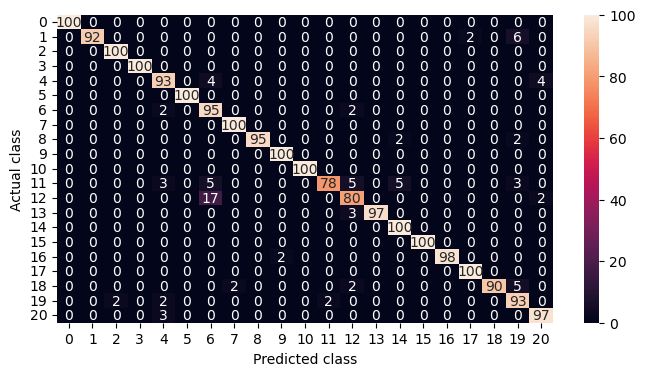

In [249]:
# Using seaborn to display the confusion matrix using the predicted labels and the correct labels
cm_cnn = metrics.confusion_matrix(y_test, cnn_predictedLabels, normalize='true')
cm_cnn*=100
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(cm_cnn, annot=True, fmt='.0f')
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show(block=False)

### Accuracy percentage by category

The accuracy percentages along with the exact number of images that were classified correctly out of the total in each class are displayed here for clarity.

In [237]:
correct, incorrect, total = np.zeros(21),np.zeros(21),np.zeros(21)
for i in range(len(y_test)):
    total[y_test[i]] += 1
    if (y_test[i] == cnn_predictedLabels[i]):
        correct[y_test[i]] += 1
    else:
        incorrect[y_test[i]] += 1

for i in range(21):
    print("Category", i + 1)
    print(round((correct[i]/total[i])*100), '%')
    print((int)(correct[i]), "out of", (int)(total[i]), "classified correctly")
    print()

Category 1
100 %
39 out of 39 classified correctly

Category 2
92 %
45 out of 49 classified correctly

Category 3
100 %
36 out of 36 classified correctly

Category 4
100 %
46 out of 46 classified correctly

Category 5
93 %
25 out of 27 classified correctly

Category 6
100 %
35 out of 35 classified correctly

Category 7
95 %
38 out of 40 classified correctly

Category 8
100 %
47 out of 47 classified correctly

Category 9
95 %
41 out of 43 classified correctly

Category 10
100 %
42 out of 42 classified correctly

Category 11
100 %
35 out of 35 classified correctly

Category 12
78 %
29 out of 37 classified correctly

Category 13
80 %
33 out of 41 classified correctly

Category 14
97 %
29 out of 30 classified correctly

Category 15
100 %
41 out of 41 classified correctly

Category 16
100 %
40 out of 40 classified correctly

Category 17
98 %
46 out of 47 classified correctly

Category 18
100 %
44 out of 44 classified correctly

Category 19
90 %
37 out of 41 classified correctly

Category 20

### Cells for saving/loading the model training history

In the case that we want to restore the full training history of a prior training run, the training history can be saved to a file and then reloaded. To save multiple files, the files will need to be renamed in the directory they're saved to and then renamed back when reloading.

In [197]:
if (cnn_history != None):
    with open('trainHistoryCNNDict', 'wb') as file_pi:
        pickle.dump(cnn_history.history, file_pi)

In [225]:
if(exists('trainHistoryCNNDict')):
    with open('trainHistoryCNNDict', "rb") as file_pi:
        cnn_historyDict = pickle.load(file_pi)

## Fully Connected ANN

This section contains the building, training, testing and evaluation of the ANN model

### First, extracting features from image data using HOG

Since the ANN is not capable of automatic feature extraction of images, the Histogram of Oriented Gradients feature extraction method is used here to acquire feature vectors for each image to be used by the ANN in training and testing.

In [4]:
if(not pre_ext):
    print("Extracting features from image data...")
    
    hog_feature = skimage.feature.hog(DSimages[0,:,:,:], pixels_per_cell=[8,8], cells_per_block=[2,2], visualize=False,channel_axis=2)
    x_data = np.array([hog_feature])

    for i in range (1,labels.shape[0]):
        hog_feature = skimage.feature.hog(DSimages[i,:,:,:], pixels_per_cell=[8,8], cells_per_block=[2,2], visualize=False,channel_axis=2)
        x_data = np.append(x_data,[hog_feature],axis=0)

    np.save('hog_features', x_data)
    
    print("Done.")
    
else:
    print("Using loaded features")

Using loaded features
(8400, 1296)


### Performing train/test/val split

In [5]:
# Same process as with the CNN but using the feature vector data from HOG

x_train, x_test, y_train, y_test = train_test_split(x_data, labels, train_size=0.9, random_state=2)

val_split = y_test.shape[0]/y_train.shape[0]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, random_state=2)

classes = len(np.unique(y_train))

### Performing dimension reduction with LDA

The initial feature vectors acquired from HOG contain too many features, leading to overfitting. As a result, LDA is used to apply dimension reduction to the data, reducing the number of features down to a much more reasonable 20 from 1296.

In [6]:
LDAmodel = LinearDiscriminantAnalysis(n_components = 20).fit(x_data, labels)
x_train_r = LDAmodel.transform(x_train)
x_test_r = LDAmodel.transform(x_test)
x_val_r = LDAmodel.transform(x_val)

### Building the model

In [40]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath_nn2,save_weights_only=True,monitor='val_sparse_categorical_accuracy',
                                                mode='max',save_best_only=True)

# The ANN model uses a simple architecture of only 4 layers and requires no explicit techniques
# to combat overfitting. Any additional layers were found to reduce performance.
nn_model = tf.keras.Sequential()
nn_model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu, input_shape = i_shape))
nn_model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(classes, activation=tf.nn.softmax))

nn_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate = 0.001),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=tf.keras.metrics.SparseCategoricalAccuracy())

### Fit model to training data

This process and the testing/experimentation/evaluation processes occur the same way and with the same reasoning as the CNN

In [41]:
with tf.device('/GPU:0'):
    nn_history = nn_model.fit(x_train_r, y_train, epochs=100, validation_data=(x_val_r,y_val), callbacks=[checkpoint])

Epoch 1/100
210/210 [==============================] - 2s 9ms/step - loss: 2.9616 - sparse_categorical_accuracy: 0.1607 - val_loss: 2.8615 - val_sparse_categorical_accuracy: 0.2857
Epoch 2/100
210/210 [==============================] - 2s 9ms/step - loss: 2.7476 - sparse_categorical_accuracy: 0.4095 - val_loss: 2.6375 - val_sparse_categorical_accuracy: 0.4869
Epoch 3/100
210/210 [==============================] - 2s 8ms/step - loss: 2.4947 - sparse_categorical_accuracy: 0.5455 - val_loss: 2.3674 - val_sparse_categorical_accuracy: 0.5738
Epoch 4/100
210/210 [==============================] - 2s 8ms/step - loss: 2.2071 - sparse_categorical_accuracy: 0.6257 - val_loss: 2.0777 - val_sparse_categorical_accuracy: 0.6393
Epoch 5/100
210/210 [==============================] - 2s 9ms/step - loss: 1.9201 - sparse_categorical_accuracy: 0.6829 - val_loss: 1.8040 - val_sparse_categorical_accuracy: 0.6667
Epoch 6/100
210/210 [==============================] - 2s 9ms/step - loss: 1.6631 - sparse_cate

210/210 [==============================] - 2s 9ms/step - loss: 0.5622 - sparse_categorical_accuracy: 0.8268 - val_loss: 0.6175 - val_sparse_categorical_accuracy: 0.8036
Epoch 47/100
210/210 [==============================] - 2s 8ms/step - loss: 0.5599 - sparse_categorical_accuracy: 0.8275 - val_loss: 0.6178 - val_sparse_categorical_accuracy: 0.8024
Epoch 48/100
210/210 [==============================] - 2s 8ms/step - loss: 0.5576 - sparse_categorical_accuracy: 0.8269 - val_loss: 0.6167 - val_sparse_categorical_accuracy: 0.8000
Epoch 49/100
210/210 [==============================] - 2s 8ms/step - loss: 0.5555 - sparse_categorical_accuracy: 0.8275 - val_loss: 0.6166 - val_sparse_categorical_accuracy: 0.8012
Epoch 50/100
210/210 [==============================] - 2s 8ms/step - loss: 0.5533 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.6145 - val_sparse_categorical_accuracy: 0.8012
Epoch 51/100
210/210 [==============================] - 2s 8ms/step - loss: 0.5511 - sparse_categorical

### Testing model

27/27 [==============================] - 0s 6ms/step - loss: 0.6200 - sparse_categorical_accuracy: 0.8060


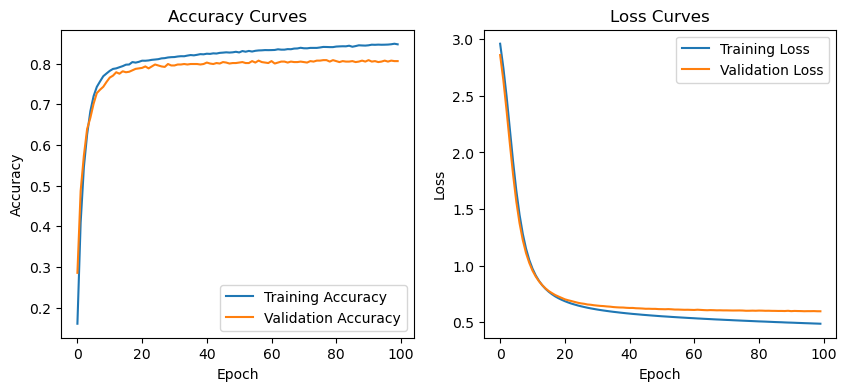

In [42]:
#nn_model.load_weights('Weights\\NN\checkpoint_file_nn2_candidate2')
nn_model.load_weights(checkpoint_filepath_nn2)

predictions = nn_model.predict(x_test_r)

nn_predictedLabels=np.argmax(predictions,axis=1)

test_loss_nn, test_accuracy_nn = nn_model.evaluate(x_test_r,y_test)


try: nn_history
except NameError: nn_history = None

if (nn_history != None):
    nn_historyDict = nn_history.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.plot(nn_historyDict['sparse_categorical_accuracy'], label='Training Accuracy')
    ax1.plot(nn_historyDict['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    ax1.set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy Curves')
    ax2.plot(nn_historyDict['loss'], label='Training Loss')
    ax2.plot(nn_historyDict['val_loss'], label='Validation Loss')
    ax2.set(xlabel='Epoch', ylabel='Loss', title='Loss Curves')
    ax1.legend()
    ax2.legend()
    plt.show()

### Accuracy and loss of ANN model on train, val and test datasets

In [44]:
val_accuracy_array = nn_historyDict['val_sparse_categorical_accuracy']
val_loss_array = nn_historyDict['val_loss']
train_accuracy_array = nn_historyDict['sparse_categorical_accuracy']
loss_array = nn_historyDict['loss']

index = np.argmax(val_accuracy_array)

val_accuracy_nn = val_accuracy_array[index]
val_loss_nn = val_loss_array[index]
train_accuracy_nn = train_accuracy_array[index]
train_loss_nn = loss_array[index]


print("train_acc:",train_accuracy_nn, "- train_loss:",train_loss_nn)
print("val_acc:", val_accuracy_nn, "- val_loss:",val_loss_nn)
print("test_acc:", test_accuracy_nn, "- test_loss:",test_loss_nn)

train_acc: 0.8407738208770752 - train_loss: 0.5109991431236267
val_acc: 0.8083333373069763 - val_loss: 0.5998807549476624
test_acc: 0.8059523701667786 - test_loss: 0.6199565529823303


### Evaluating performance
The ANN has very smooth training and validation curves compared with the CNN, likely due to the the lack of regularisation techniques such as batch normalisation in the model. The curves are also relatively close together, which is unsurprising due to the dimension reduction technique substantially reducing the number of features to combat overfitting combined with the relative simplicity of the model. Earlier tests did not utilise such techniques and featured significantly more overfitting. Ultimately, the overall performance metrics of the ANN are clearly worse than the CNN, having both higher loss and lower accuracy in all dataset splits. This is not surprising however due to the fact that standard fully connected neural networks were not really specially designed for image classifcation like CNNs were, so this lower performance for an image classification task by the ANN only serves to demonstrate the efficacy of a CNN based model when it's performing to its stengths.

### Confusion matrix
As can be seen from this confusion matrix, the fully connected neural network does not perform as well across the board when compared with the CNN, although its performance is not too bad. It appears to actually outperform the CNN in one class, being class 11, although it also performs significantly worse in classes such as 13, 15 and 20.

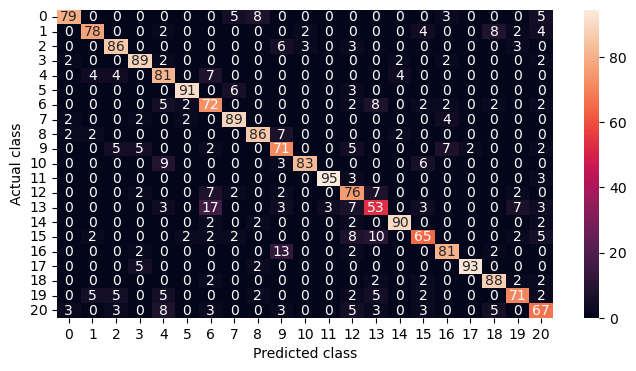

In [45]:
cm_nn = metrics.confusion_matrix(y_test, nn_predictedLabels, normalize='true')
cm_nn*=100
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(cm_nn, annot=True, fmt='.0f')
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show(block=False)

### Accuracy percentage by category

In [46]:
correct, incorrect, total = np.zeros(21),np.zeros(21),np.zeros(21)
for i in range(len(y_test)):
    total[y_test[i]] += 1
    if (y_test[i] == nn_predictedLabels[i]):
        correct[y_test[i]] += 1
    else:
        incorrect[y_test[i]] += 1

for i in range(21):
    print("Category", i + 1)
    print(round((correct[i]/total[i])*100), '%')
    print((int)(correct[i]), "out of", (int)(total[i]), "classified correctly")
    print()

Category 1
79 %
31 out of 39 classified correctly

Category 2
78 %
38 out of 49 classified correctly

Category 3
86 %
31 out of 36 classified correctly

Category 4
89 %
41 out of 46 classified correctly

Category 5
81 %
22 out of 27 classified correctly

Category 6
91 %
32 out of 35 classified correctly

Category 7
72 %
29 out of 40 classified correctly

Category 8
89 %
42 out of 47 classified correctly

Category 9
86 %
37 out of 43 classified correctly

Category 10
71 %
30 out of 42 classified correctly

Category 11
83 %
29 out of 35 classified correctly

Category 12
95 %
35 out of 37 classified correctly

Category 13
76 %
31 out of 41 classified correctly

Category 14
53 %
16 out of 30 classified correctly

Category 15
90 %
37 out of 41 classified correctly

Category 16
65 %
26 out of 40 classified correctly

Category 17
81 %
38 out of 47 classified correctly

Category 18
93 %
41 out of 44 classified correctly

Category 19
88 %
36 out of 41 classified correctly

Category 20
71 %
29 o

### Cells for saving/loading the model training history

In [47]:
if(nn_history != None):
    with open('trainHistoryNNDict', 'wb') as file_pi:
        pickle.dump(nn_history.history, file_pi)

In [12]:
if(exists('trainHistoryNNDict')):
    with open('trainHistoryNNDict', "rb") as file_pi:
        nn_historyDict = pickle.load(file_pi)